<a href="https://colab.research.google.com/github/nishuchy/AI-works/blob/main/Ethereum_Preictive_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import shutil

# Remove existing contents from the mountpoint
if os.path.exists('/content/drive'):
  shutil.rmtree('/content/drive')

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


**Model 1:  Class Prediction (Up, Down, Sideway)**

In [ ]:
!pip install ta


In [ ]:
import numpy as np
import pandas as pd
import ta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ETH_2020_2025.csv")

# assume already time ordered
df.head()


,timestamp,open,high,low,close,volume,transactions,vwap
0,1577836800000,129.215,129.29,128.20,128.360,586.091661,318,128.5752
1,1577837400000,128.360,129.24,128.23,129.080,1257.362749,266,128.8887
2,1577838000000,129.070,129.11,128.17,128.834,4199.633481,278,128.7702
3,1577838600000,128.410,129.20,128.25,128.410,568.821464,232,128.5079
4,1577839200000,129.180,129.18,128.21,128.220,1889.440471,541,128.5644


In [ ]:
# RSI
df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()

# MACD
macd = ta.trend.MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

# EMA
df['ema20'] = ta.trend.EMAIndicator(df['close'], 20).ema_indicator()
df['ema50'] = ta.trend.EMAIndicator(df['close'], 50).ema_indicator()

# ATR
df['atr'] = ta.volatility.AverageTrueRange(
    df['high'], df['low'], df['close'], 14
).average_true_range()

# ADX
df['adx'] = ta.trend.ADXIndicator(
    df['high'], df['low'], df['close'], 14
).adx()

df.dropna(inplace=True)


In [ ]:
threshold = 0.002  # 0.1%

df['future_return'] = df['close'].shift(-1) / df['close'] - 1

def label(x):
    if x > threshold:
        return 2
    elif x < -threshold:
        return 0
    else:
        return 1

df['target'] = df['future_return'].apply(label)
df.dropna(inplace=True)


In [ ]:
features = [
    'open','high','low','close','volume',
    'rsi','macd','macd_signal',
    'ema20','ema50',
    'atr','adx'
]

X = df[features]
y = df['target']


In [ ]:
split = int(len(df) * 0.8)

X_train_raw = X.iloc[:split]
X_test_raw  = X.iloc[split:]
y_train = y.iloc[:split]
y_test  = y.iloc[split:]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


In [ ]:
def create_sequences(X, y, lookback=24):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
def build_lstm(input_shape):
    model = tf.keras.Sequential([
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

lstm = build_lstm(X_train_seq.shape[1:])
lstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.6203 - loss: 0.8599 - val_accuracy: 0.7274 - val_loss: 0.7408
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6251 - loss: 0.8442 - val_accuracy: 0.7264 - val_loss: 0.7431
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6261 - loss: 0.8422 - val_accuracy: 0.7267 - val_loss: 0.7431
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6278 - loss: 0.8398 - val_accuracy: 0.7273 - val_loss: 0.7535
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6283 - loss: 0.8384 - val_accuracy: 0.7272 - val_loss: 0.7405
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6279 - loss: 0.8383 - val_accuracy: 0.7273 - val_loss: 0.7512
Epoch 7/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6287 - loss: 0.8370 - val_accuracy: 0.7281 - val_loss: 0.7453
Epoch 8/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6282 - loss: 0

In [ ]:
def build_bilstm(input_shape):
    model = tf.keras.Sequential([
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

bilstm = build_bilstm(X_train_seq.shape[1:])
bilstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.6213 - loss: 0.8571 - val_accuracy: 0.7274 - val_loss: 0.7482
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6255 - loss: 0.8463 - val_accuracy: 0.7276 - val_loss: 0.7482
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6269 - loss: 0.8418 - val_accuracy: 0.7274 - val_loss: 0.7467
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6262 - loss: 0.8416 - val_accuracy: 0.7274 - val_loss: 0.7596
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6283 - loss: 0.8391 - val_accuracy: 0.7273 - val_loss: 0.7496
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6271 - loss: 0.8382 - val_accuracy: 0.7277 - val_loss: 0.7512
Epoch 7/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6272 - loss: 0.8381 - val_accuracy: 0.7270 - val_loss: 0.7432
Epoch 8/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6280 - loss: 0

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dense(inputs.shape[-1])(ff)
    x = LayerNormalization(epsilon=1e-6)(ff + x)
    return x

def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, 64, 4, 128)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x) # Fixed: call the Dense layer with x as input
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

transformer = build_transformer(X_train_seq.shape[1:])
transformer.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.6205 - loss: 0.8613 - val_accuracy: 0.7258 - val_loss: 0.7478
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6242 - loss: 0.8521 - val_accuracy: 0.7267 - val_loss: 0.7559
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6243 - loss: 0.8499 - val_accuracy: 0.7264 - val_loss: 0.7514
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6252 - loss: 0.8472 - val_accuracy: 0.7274 - val_loss: 0.7487
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6279 - loss: 0.8445 - val_accuracy: 0.7256 - val_loss: 0.7465
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6255 - loss: 0.8463 - val_accuracy: 0.7263 - val_loss: 0.7429
Epoch 7/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6268 - loss: 0.8439 - val_accuracy: 0.7243 - val_loss: 0.7514
Epoch 8/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6267 - loss: 0.8442 -

In [ ]:
lstm_probs = lstm.predict(X_test_seq)
bilstm_probs = bilstm.predict(X_test_seq)
transformer_probs = transformer.predict(X_test_seq)

final_probs = (lstm_probs + bilstm_probs + transformer_probs) / 3
final_pred = np.argmax(final_probs, axis=1)

print("Ensemble Accuracy:", accuracy_score(y_test_seq, final_pred))
print(classification_report(y_test_seq, final_pred))


1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Ensemble Accuracy: 0.6390981020184883
              precision    recall  f1-score   support

           0       0.34      0.01      0.02     11424
           1       0.65      0.99      0.78     40163
           2       0.37      0.05      0.09     11480

    accuracy                           0.64     63067
   macro avg       0.45      0.35      0.30     63067
weighted avg       0.54      0.64      0.52     63067



**Model 2: Next hour Close Price Prediction**

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=643cdc26cf7fad07fe81ec9fe7c52dfbd4ccf89702d61a7847e6592e58cebcb0
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
import numpy as np
import pandas as pd
import ta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/BTC_2020_2025.csv")
df = df.reset_index(drop=True)
df.head()


,timestamp,open,high,low,close,volume,transactions,vwap
0,1577836800000,7165.720000,7208.2,7136.05,7161.700000,200.991649,746,7156.5143
1,1577837400000,7163.620000,7203.9,7152.25,7190.276057,61.287264,568,7171.3307
2,1577838000000,7190.276057,7197.9,7151.60,7157.000000,181.113288,488,7179.7714
3,1577838600000,7194.200000,7200.0,7156.22,7157.300000,44.150353,395,7174.6216
4,1577839200000,7159.510000,7201.9,7153.40,7155.200000,77.830527,523,7172.0314


In [ ]:
# RSI
df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()

# MACD
macd = ta.trend.MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

# EMA
df['ema20'] = ta.trend.EMAIndicator(df['close'], 20).ema_indicator()
df['ema50'] = ta.trend.EMAIndicator(df['close'], 50).ema_indicator()

# ATR
df['atr'] = ta.volatility.AverageTrueRange(
    df['high'], df['low'], df['close'], 14
).average_true_range()

# ADX
df['adx'] = ta.trend.ADXIndicator(
    df['high'], df['low'], df['close'], 14
).adx()

df.dropna(inplace=True)



In [ ]:
df['log_return'] = np.log(df['close'].shift(-1) / df['close'])
df.dropna(inplace=True)


In [ ]:
features = [
    'open','high','low','close','volume',
    'rsi','macd','macd_signal',
    'ema20','ema50',
    'atr','adx'
]

X = df[features]
y = df['log_return']


In [ ]:
split = int(len(df) * 0.8)

X_train_raw = X.iloc[:split]
X_test_raw  = X.iloc[split:]

y_train = y.iloc[:split]
y_test  = y.iloc[split:]



In [ ]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train_raw)
X_test_scaled  = X_scaler.transform(X_test_raw)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1,1))



In [ ]:
def create_sequences(X, y, lookback=24):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Custom metric: counts prediction within ±5% of true value
def regression_accuracy(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.abs(y_true - y_pred) <= 0.05 * tf.abs(y_true), tf.float32)
    )

def build_lstm(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # regression output
    ])

    model.compile(
        optimizer=Adam(0.001),
        loss=tf.keras.losses.Huber(),       # regression loss
        metrics=['mae', regression_accuracy]  # MAE + pseudo-accuracy
    )

    return model

# Build the model
lstm = build_lstm(X_train_seq.shape[1:])

# Train the model
history = lstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 7.2978e-04 - mae: 0.0172 - regression_accuracy: 0.0066 - val_loss: 2.4765e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0028
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 5.2466e-06 - mae: 0.0019 - regression_accuracy: 0.0074 - val_loss: 2.5863e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0131
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 5.2591e-06 - mae: 0.0019 - regression_accuracy: 0.0076 - val_loss: 2.5292e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0104
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 5.1369e-06 - mae: 0.0019 - regression_accuracy: 0.0081 - val_loss: 2.5773e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0132
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 5.2580e-06 - mae: 0.0019 - regression_accuracy: 0.0066 - val_loss: 2.5078e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0087
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Custom regression accuracy metric (within ±5% of true value)
def regression_accuracy(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.abs(y_true - y_pred) <= 0.05 * tf.abs(y_true), tf.float32)
    )

def build_bilstm(input_shape):
    model = tf.keras.Sequential([
        Bidirectional(LSTM(64), input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)  # regression output
    ])

    model.compile(
        optimizer=Adam(0.001),
        loss='mse',  # mean squared error for regression
        metrics=['mae', regression_accuracy]  # MAE + pseudo-accuracy
    )

    return model

# Build the model
bilstm = build_bilstm(X_train_seq.shape[1:])

# Train the model
history = bilstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0015 - mae: 0.0145 - regression_accuracy: 0.0055 - val_loss: 4.9246e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0033
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 1.0794e-05 - mae: 0.0019 - regression_accuracy: 0.0069 - val_loss: 4.9081e-06 - val_mae: 0.0015 - val_regression_accuracy: 3.9928e-04
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 1.0400e-05 - mae: 0.0019 - regression_accuracy: 0.0074 - val_loss: 4.9563e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0064
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 1.0320e-05 - mae: 0.0019 - regression_accuracy: 0.0067 - val_loss: 5.0602e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0103
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 1.0104e-05 - mae: 0.0019 - regression_accuracy: 0.0066 - val_loss: 5.0393e-06 - val_mae: 0.0015 - val_regression_accuracy: 0.0099
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Custom regression accuracy metric (within ±5% of true value)
def regression_accuracy(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.abs(y_true - y_pred) <= 0.05 * tf.abs(y_true), tf.float32)
    )

# Transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dense(inputs.shape[-1])(ff)
    x = LayerNormalization(epsilon=1e-6)(ff + x)
    return x

# Build Transformer regression model
def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)  # regression output

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(0.001),
        loss='mse',                        # mean squared error for regression
        metrics=['mae', regression_accuracy]  # MAE + pseudo-accuracy
    )
    return model

# Build and train the model
transformer = build_transformer(X_train_seq.shape[1:])
history = transformer.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.0068 - mae: 0.0279 - regression_accuracy: 0.0053 - val_loss: 1.0468e-05 - val_mae: 0.0026 - val_regression_accuracy: 0.0142
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 2.6448e-05 - mae: 0.0033 - regression_accuracy: 0.0125 - val_loss: 1.0376e-05 - val_mae: 0.0026 - val_regression_accuracy: 0.0161
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.0726e-05 - mae: 0.0030 - regression_accuracy: 0.0129 - val_loss: 1.1079e-05 - val_mae: 0.0028 - val_regression_accuracy: 0.0141
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 1.6412e-05 - mae: 0.0027 - regression_accuracy: 0.0132 - val_loss: 6.0273e-06 - val_mae: 0.0016 - val_regression_accuracy: 0.0082
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 1.4279e-05 - mae: 0.0025 - regression_accuracy: 0.0133 - val_loss: 1.9157e-05 - val_mae: 0.0038 - val_regression_accuracy: 0.0091
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━

In [ ]:
lstm_pred = lstm.predict(X_test_seq)
bilstm_pred = bilstm.predict(X_test_seq)
transformer_pred = transformer.predict(X_test_seq)

final_pred = (lstm_pred + bilstm_pred + transformer_pred) / 3


1971/1971 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
mae = mean_absolute_error(y_test_seq, final_pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, final_pred))

print("Ensemble MAE:", mae)
print("Ensemble RMSE:", rmse)

def regression_accuracy(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 0.05 * np.abs(y_true))

import numpy as np

threshold = 0.05  # ±5%
reg_acc = np.mean(np.abs(y_test_seq - final_pred) <= threshold * np.abs(y_test_seq))

print("Ensemble Regression Accuracy:", reg_acc)


Ensemble MAE: 0.0013665571532182842
Ensemble RMSE: 0.002128010791913588


**Cross-Asset Analysis:**

Data merge

Epoch 1/10, Loss: 0.6922
Epoch 2/10, Loss: 0.6919
Epoch 3/10, Loss: 0.6918
Epoch 4/10, Loss: 0.6916
Epoch 5/10, Loss: 0.6915
Epoch 6/10, Loss: 0.6915
Epoch 7/10, Loss: 0.6914
Epoch 8/10, Loss: 0.6913
Epoch 9/10, Loss: 0.6912
Epoch 10/10, Loss: 0.6911
Macro F1 Score: 0.513862889225863
Sharpe Ratio: -18.75297374810069
Max Drawdown: -0.999999999999946


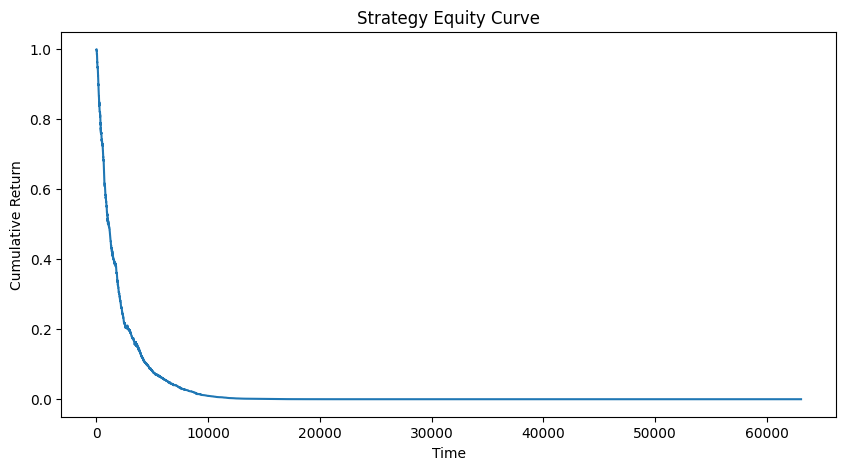

In [6]:

# =========================================================
# 1. IMPORTS
# =========================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# =========================================================
# 2. LOAD DATA
# =========================================================
btc = pd.read_csv("/content/drive/MyDrive/BTC_2020_2025.csv")
eth = pd.read_csv("/content/drive/MyDrive/ETH_2020_2025.csv")

# Convert timestamp (change to 's' if needed)
btc['timestamp'] = pd.to_datetime(btc['timestamp'], unit='ms')
eth['timestamp'] = pd.to_datetime(eth['timestamp'], unit='ms')

# Rename close columns
btc = btc.rename(columns={'close': 'close_BTC'})
eth = eth.rename(columns={'close': 'close_ETH'})

# Merge
df = pd.merge(eth, btc, on='timestamp')
df = df.sort_values("timestamp").reset_index(drop=True)

# =========================================================
# 3. FEATURE ENGINEERING (Cross-Asset)
# =========================================================
df['ETH_ret'] = np.log(df['close_ETH'] / df['close_ETH'].shift(1))
df['BTC_ret'] = np.log(df['close_BTC'] / df['close_BTC'].shift(1))

df['rolling_corr'] = df['ETH_ret'].rolling(24).corr(df['BTC_ret'])
df['BTC_volatility'] = df['BTC_ret'].rolling(24).std()

df = df.dropna().reset_index(drop=True)

# Target: next hour direction
df['target'] = (df['ETH_ret'].shift(-1) > 0).astype(int)
df = df.dropna().reset_index(drop=True)

# =========================================================
# 4. SEQUENCE PREPARATION
# =========================================================
features = ['ETH_ret', 'BTC_ret', 'rolling_corr', 'BTC_volatility']
lookback = 24

def create_sequences(X, y):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

X = df[features].values
y = df['target'].values

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_seq, y_seq = create_sequences(X, y)

# Train/Test split (time-based)
split = int(len(X_seq) * 0.8)

X_train = X_seq[:split]
X_test = X_seq[split:]
y_train = y_seq[:split]
y_test = y_seq[split:]

# =========================================================
# 5. DATALOADER (Memory Safe)
# =========================================================
batch_size = 64

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# =========================================================
# 6. LSTM MODEL
# =========================================================
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = LSTMClassifier(len(features)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =========================================================
# 7. TRAINING LOOP
# =========================================================
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# =========================================================
# 8. EVALUATION (Macro F1)
# =========================================================
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        output = model(xb)
        preds = torch.argmax(output, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(yb.numpy())

macro_f1 = f1_score(all_true, all_preds, average='macro')
print("Macro F1 Score:", macro_f1)

# =========================================================
# 9. TRADING SIMULATION
# =========================================================
df_test = df.iloc[split+lookback:].copy().reset_index(drop=True)

df_test['signal'] = all_preds
df_test['strategy_ret'] = df_test['signal'].shift(1) * df_test['ETH_ret']

# Transaction cost
cost = 0.0015
df_test['trade'] = df_test['signal'].diff().abs()
df_test['strategy_ret'] -= df_test['trade'] * cost

df_test['cum_strategy'] = (1 + df_test['strategy_ret']).cumprod()

# =========================================================
# 10. PERFORMANCE METRICS
# =========================================================
sharpe = df_test['strategy_ret'].mean() / df_test['strategy_ret'].std() * np.sqrt(365*24)

cum = df_test['cum_strategy']
rolling_max = cum.cummax()
drawdown = (cum - rolling_max) / rolling_max
max_dd = drawdown.min()

print("Sharpe Ratio:", sharpe)
print("Max Drawdown:", max_dd)

# =========================================================
# 11. EQUITY CURVE
# =========================================================
plt.figure(figsize=(10,5))
plt.plot(df_test['cum_strategy'])
plt.title("Strategy Equity Curve")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()
